# Learning forcing terms for SPDE
Wave SPDE from "Numerical solution of the (stochastic) wave equation"
from JOHN B. WALSH, see: https://www.math.ubc.ca/~walsh/waveq.pdf

### Define stochastic wave equation:

$$
\frac{\partial^2 u}{\partial t^2}=\frac{\partial^2 u}{\partial x^2}+f(x,t,u)+g(x,t,u)\dot{W},\ x\in\mathbb{R}, t\in\mathbb{R}^+,
$$

$$
u(x,0)=u_0(x),\ \frac{\partial u}{\partial t}(x,0)=v_0(x),\ x\in\mathbb{R}.
$$

Here, $f$ is the deterministic and $g$ the stochastic forcing term. We show how to learn these from SPDE data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from time import time as measure_time

from sde.spde_utils import SPDEUtils
import tensorflow as tf

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

%load_ext autoreload
%autoreload 2

In [2]:
# Define example parameters
random_seed = 1
step_size = 1e-3
space_size = 1
time_size = 2
space = np.arange(int(space_size/step_size))*step_size
time = np.arange(int(time_size/step_size))*step_size

g_constant = 0.05

# these are the forcing terms we want to learn
f = lambda x, t, u: np.sin(4*np.pi*x) * 5
g = lambda x, t, u: g_constant * (1 + np.exp(-(x-space_size/2)**2 * 150))

# network parameters
step_size_network = step_size   # step size used in training. May be different from the SPDE size.

n_layers = 2
n_dim_per_layer = 50

n_dimensions = 1

ACTIVATIONS = tf.nn.elu
VALIDATION_SPLIT = .1
BATCH_SIZE = 512
N_EPOCHS = 100

# only diagonal diffusivity matrix (does not matter since we are in 1D)
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [3]:
# define the example data
u0 = np.zeros((len(space),)) + np.sin(2*np.pi*space) * 0 + np.exp(-(space-space_size/2)**2 * 150)/20
v0 = np.zeros((len(space),))
v0 = -np.gradient(u0, step_size)*2  # define initial velocity such that the wave moves to the right


def compute_example(*args, **kwargs):
    ut = SPDEUtils.integrate_stochastic_wave(*args, **kwargs)
    return ut


def plot_example(ut):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    im1 = ax.imshow(ut, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-1, vmax=1)
    ax.set_xlabel('Space')
    ax.set_ylabel('Time')
    fig.colorbar(im1, cax=cax, orientation='vertical')
    fig.tight_layout()

    fig.savefig('figures/example7_data.pdf')
    fig.savefig('figures/example7_data.png')

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.plot(ut[0:(len(time)//5):(len(time)//5//5), :].T)
    #ax[1].set_xlim([0, 500])
    fig.tight_layout()

Data ut shape: (2000, 500)


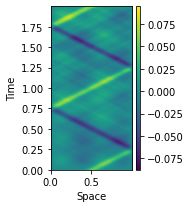

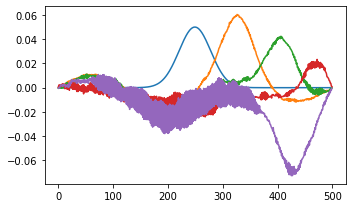

In [4]:
# Test on simple example with periodic boundaries
ut = compute_example(u0, v0, f, g, time, space, random_seed=random_seed, periodic_boundary=False);
print('Data ut shape:', ut.shape)
plot_example(ut)

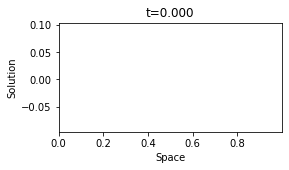

In [5]:
if False:
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.set_xlim((np.min(space), np.max(space)))
    ax.set_ylim((np.min(ut) * 1.1, np.max(ut) * 1.1))
    ax.set_xlabel('Space')
    ax.set_ylabel('Solution')
    ax_title = ax.set_title(f't={0:0.3f}')
    line, = ax.plot([], [], lw=.5)
    n_frames = 300

    def animate(k):
        idx = int((k * ut.shape[0] // n_frames)) % ut.shape[0]
        line.set_data(space[::2], ut[idx, :])
        ax.set_title(f't={time[k]:0.3f}')
        return (line, )


    def init():
        line.set_data([], [])
        return (line, )


    # create animation using the animate() function with no repeat
    myAnimation = animation.FuncAnimation(fig, animate, frames=n_frames,
                                          interval=10, blit=True,
                                          repeat=False)

    # save animation at 30 frames per second
    myAnimation.save('figures/myAnimation.gif', writer='pillow', fps=30, dpi=150)

    animate(1)

In [6]:
# split the data into the stencil, and reformulate the numerical scheme such that it turns into the default SDE form:
# u_np1 = u_n + f(u_n) + g(u_n) * dW
# we need to sample the space at every other point because the solution is also given on a staggered grid.
u_n, p_n, u_np1 = SPDEUtils.split_forced_wave_spde_data(ut, space[::2], time, step_size)

print('u_n', u_n.shape)
print('p_n', p_n.shape)
print('u_np1', u_np1.shape)

u_n (995004, 1)
p_n (995004, 2)
u_np1 (995004, 1)


## Learn the forcing terms
Now that the data is prepared, we can use the normal SDE learning framework to extract the forcing terms.

In [7]:
# define the neural network model we will use for identification
encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_parameter_dimensions=2,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="SPDE_forcing",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder,
                                method="euler",
                                step_size=np.array(step_size_network).astype(np.float64),
                                n_parameters=p_n.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adamax())

sde_i = SDEIdentification(model=model)

Model: "SPDE_forcing_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 SPDE_forcing_inputs (InputLaye  [(None, 3)]         0           []                               
 r)                                                                                               
                                                                                                  
 SPDE_forcing_mean_hidden_0 (De  (None, 50)          200         ['SPDE_forcing_inputs[0][0]']    
 nse)                                                                                             
                                                                                                  
 SPDE_forcing_std_hidden_0 (Den  (None, 50)          200         ['SPDE_forcing_inputs[0][0]']    
 se)                                                                  

training for 100 epochs with 895503 data points, validating with 99500
The average loss for epoch 99 is -0.2168555206 

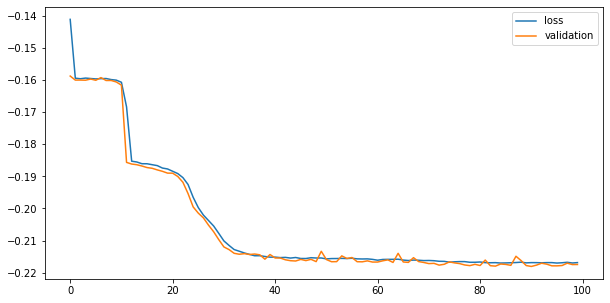

In [8]:
hist = sde_i.train_model(u_n.astype(np.float64), u_np1.astype(np.float64),
                         p_n=p_n.astype(np.float64),
                         validation_split=VALIDATION_SPLIT,
                         n_epochs=N_EPOCHS,
                         batch_size=BATCH_SIZE)

fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss')
hist_axes.plot(hist.history["val_loss"], label='validation')
hist_axes.legend()

In [9]:
print(f'loss training: {hist.history["loss"][-1]}, validation: {hist.history["val_loss"][-1]}')

loss training: -0.2168555206472474, validation: -0.21744827242744807


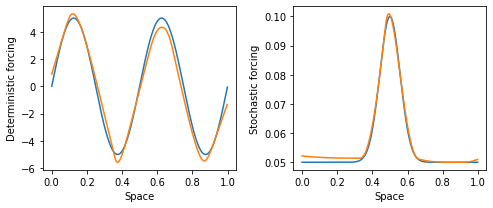

In [10]:
# visualize the results against the true forcing functions

# visualize the results against the true forcing functions

def plot_forcings_space(ut, network):
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))

    f_true = f(space, time[0], ut[0, :])
    g_true = g(space, time[0], ut[0, :])
    state_k = np.array([ut[0, :]]).reshape(-1, 1)*1
    param_k = np.zeros((ut.shape[1], 2))
    param_k[:, 0] = time[0]
    param_k[:, 1] = space[::2]
    model_f, model_g = model.call_xn(state_k, param_xn=param_k)
    f_approx = tf.keras.backend.eval(model_f).ravel()

    # this is an important scaling here, as from the SDE formulation to the SPDE formulation we loose the factor sqrt(2 h^2 / h)
    g_approx = np.sqrt(step_size ** 2 / step_size * 2) * tf.keras.backend.eval(model_g).ravel()

    ax[0].plot(space, f_true)
    ax[0].plot(space[::2], f_approx)
    ax[0].set_xlabel('Space')
    ax[0].set_ylabel('Deterministic forcing')

    ax[1].plot(space, g_true)
    ax[1].plot(space[::2], g_approx)
    ax[1].set_xlabel('Space')
    ax[1].set_ylabel('Stochastic forcing')

    fig.tight_layout()

    fig.savefig('figures/example7_wave_spde_forcings.pdf')
    fig.savefig('figures/example7_wave_spde_forcings.png')


def plot_forcings(ut, network):
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    divider1 = make_axes_locatable(ax[0])
    divider2 = make_axes_locatable(ax[1])
    divider3 = make_axes_locatable(ax[2])
    divider4 = make_axes_locatable(ax[3])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    cax3 = divider3.append_axes('right', size='5%', pad=0.05)
    cax4 = divider4.append_axes('right', size='5%', pad=0.05)

    f_true = np.zeros((len(time), len(space)))
    g_true = np.zeros((len(time), len(space)))
    f_approx = np.zeros((len(time), len(space)//2))
    g_approx = np.zeros((len(time), len(space)//2))
    for k in range(len(time)):
        f_true[k, :] = f(space, time[k], ut[k, :])
        g_true[k, :] = g(space, time[k], ut[k, :])
        state_k = np.array([ut[k, :]]).reshape(-1, 1)*1
        param_k = np.zeros((ut.shape[1], 2))
        param_k[:, 0] = time[k]
        param_k[:, 1] = space[::2]
        model_f, model_g = model.call_xn(state_k, param_xn=param_k)
        f_approx[k, :] = tf.keras.backend.eval(model_f).ravel()

        # this is an important scaling here, as from the SDE formulation to the SPDE formulation we loose the factor sqrt(2 h^2 / h)
        g_approx[k, :] = np.sqrt(step_size ** 2 / step_size * 2) * tf.keras.backend.eval(model_g).ravel()

    im1 = ax[0].imshow(f_true, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-20, vmax=20)
    ax[0].set_xlabel('Space')
    ax[0].set_ylabel('Time')
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    im2 = ax[1].imshow(f_approx, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-20, vmax=20)
    ax[1].set_xlabel('Space')
    ax[1].set_ylabel('Time')
    fig.colorbar(im2, cax=cax2, orientation='vertical')

    im3 = ax[2].imshow(g_true, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-g_constant*1.5, vmax=g_constant*1.5)
    ax[2].set_xlabel('Space')
    ax[2].set_ylabel('Time')
    fig.colorbar(im3, cax=cax3, orientation='vertical')

    im4 = ax[3].imshow(g_approx, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-g_constant*1.5, vmax=g_constant*1.5)
    ax[3].set_xlabel('Space')
    ax[3].set_ylabel('Time')
    fig.colorbar(im4, cax=cax4, orientation='vertical')

    fig.tight_layout()


plot_forcings_space(ut, encoder)
# plot_forcings(ut, encoder)

## Convergence tests
Compute the error (MSE) between the true solutions and the network solutions, for increasing number of data points.

In [11]:
def train_network(n_data_points, seed=1):
    # define model
    encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_parameter_dimensions=2,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="SPDE_forcing",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
    # encoder.summary()

    model = SDEApproximationNetwork(sde_model=encoder,
                                    method="euler",
                                    step_size=np.array(step_size_network).astype(np.float64),
                                    n_parameters=p_n.shape[1])
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-2))

    rng = np.random.default_rng(seed)
    idx = rng.permutation(np.arange(u_n.shape[0]))[:n_data_points]
    # train model with the specified number of data points
    u_n_i = u_n[idx, :]
    u_np1_i = u_np1[idx, :]
    p_n_i = p_n[idx, :]
    
    # number of iterations is fixed, so that we update all networks roughly the same number of times
    N_EPOCHS_i = N_EPOCHS * 500000 // n_data_points
    
    t0 = measure_time()
    sde_i = SDEIdentification(model=model)
    hist = sde_i.train_model(u_n_i.astype(np.float64), u_np1_i.astype(np.float64),
                         p_n=p_n_i.astype(np.float64),
                         validation_split=0.01,
                         n_epochs=N_EPOCHS_i,
                         batch_size=BATCH_SIZE)
    t1 = measure_time()
    
    # evaluate on grid data and compare to true functions in MSE
    f_true = f(space[::2], time[0], ut[0, ::2])
    g_true = g(space[::2], time[0], ut[0, ::2])
    state_k = np.array([ut[0, :]]).reshape(-1, 1)*1
    param_k = np.zeros((ut.shape[1], 2))
    param_k[:, 0] = time[0]
    param_k[:, 1] = space[::2]
    model_f, model_g = model.call_xn(state_k, param_xn=param_k)
    f_approx = tf.keras.backend.eval(model_f).ravel()

    # this is an important scaling here, as from the SDE formulation to the SPDE formulation we loose the factor sqrt(2 h^2 / h)
    g_approx = np.sqrt(step_size ** 2 / step_size * 2) * tf.keras.backend.eval(model_g).ravel()

    return {
        'f_true': f_true,
        'f_approx': f_approx,
        'mse_f': np.mean(np.square((f_approx - f_true))),
        'mse_g': np.mean(np.square((g_approx - g_true))),
        'loss': hist.history['loss'][-1],
        'val_loss': hist.history['val_loss'][-1],
        'n_data_points': n_data_points,
        'training_time': t1-t0
    }

In [12]:
train_large = False # set to True if the large training experiment must be performed

In [13]:
if train_large:
    data = []
    for k in np.linspace(3.5, 6, num=10):
        for k2 in range(10):
            data.append(train_network(int(10**k)))
    errors_df = pd.DataFrame.from_dict(data)

In [14]:
if train_large:
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))

    def plot_error(ax, y, label, loglog=True, ylabel='True mean squared error'):
        if loglog:
            ax.loglog(errors_df['n_data_points'], y, '.', label=label)
        else:
            ax.semilogx(errors_df['n_data_points'], y, '.', label=label)
        ax.legend() # loc='upper right')
        ax.set_xlabel('Data points')
        ax.set_ylabel(ylabel)

    plot_error(ax[0], errors_df['mse_f'], 'Drift')
    plot_error(ax[1], errors_df['mse_g'], 'Diffusivity')
    plot_error(ax[2], errors_df['loss'], 'Training set', loglog=False, ylabel='Euler-Maruyama loss')
    plot_error(ax[2], errors_df['val_loss'], 'Validation set', loglog=False, ylabel='Euler-Maruyama loss')

    fig.tight_layout()
    fig.savefig('figures/example7_wavepde_trueloss.pdf')
    fig.savefig('figures/example7_wavepde_trueloss.png')

In [15]:
# number of weight update iterations for the convergence test:
print((N_EPOCHS * 500000 // 10**6) * (10**6 // BATCH_SIZE))

97650
